In [3]:
import pandas as pd
import os, sys
sys.path.append(r'C:\Users\charl\Documents\GitHub\GOST_PublicGoods\GOSTNets\GOSTNets')
sys.path.append(r'C:\Users\charl\Documents\GitHub\GOST')
import GOSTnet as gn
import importlib
importlib.reload(gn)
import geopandas as gpd
import rasterio
from rasterio import features
from shapely.wkt import loads
import numpy as np

peartree version: 0.6.0 
networkx version: 2.2 
matplotlib version: 2.2.2 
osmnx version: 0.8.2 
peartree version: 0.6.0 
networkx version: 2.2 
matplotlib version: 2.2.2 
osmnx version: 0.8.2 


In [4]:
basepth = r'C:\Users\charl\Documents\GOST\Yemen'
pth = r'C:\Users\charl\Documents\GOST\Yemen\graphtool'
net_pth = r'C:\Users\charl\Documents\GOST\Yemen\YEM'
pckle = r'G_salty_time.pickle'
walk_speed = 4 
WGS = {'init':'epsg:4326'}
measure_crs = {'init':'epsg:32638'}

### Generate subset

In [140]:
subset = r'HeRAMS PHCs 2016'
acceptable_df = pd.read_csv(os.path.join(pth, 'HeRAMs_2016v2018_damages and functionality_cleaned_snapped.csv'))
print(acceptable_df.columns)
hosp_types = ['District L Rural\r Hospital','Governorate/General\r Hospital','Hospital','1']
def hospcheck(x, hosp_types):
    if x in hosp_types:
        return 'hospital'
    else:
        return 'PHC'
acceptable_df['hosp'] = acceptable_df['Facility Type2'].apply(lambda x: hospcheck(x, hosp_types))
acceptable_df = acceptable_df.drop(['Facility Type2','Name of Health Facility'], axis =1)
acceptable_df = acceptable_df.loc[acceptable_df['hosp'] == 'PHC']
#function_level = ['1','2', 1, 2]
#acceptable_df = acceptable_df.loc[acceptable_df['Functioning 2016'].isin(function_level)]
#service_level = ['1']
#acceptable_df = acceptable_df.loc[acceptable_df['Comprehensive Emergency Obstetric Care (S424)'].isin(service_level)]

Index(['Unnamed: 0', 'Latitude', 'Longitude', 'Year', 'FacilityID',
       'Governorate', 'District', 'Facility Type', 'Functioning 2016',
       'Damaged 2016', 'Name of Health Facility', 'Name of Governor ate',
       'Name of District', 'Facility Type2', 'Damaged2018',
       'Functionality2018', 'Accessibility to HF', 'geometry', 'NN',
       'NN_dist'],
      dtype='object')
4028


In [141]:
def dest_check(x):
    if x['Functioning 2016'] in function_level and x['Functionality2018'] in function_level:
        return 'unchanged'
    elif x['Functioning 2016'] in function_level and x['Functionality2018'] not in function_level:
        return 'newly_destroyed'
    elif x['Functioning 2016'] not in function_level and x['Functionality2018'] in function_level:
        return 'rebuilt'
    else:
        return 'always_destroyed'

In [142]:
acceptable_df['stat_change'] = acceptable_df.apply(lambda x: dest_check(x), axis = 1)
acceptable_df['stat_change'].value_counts()

### Generate Change Raster

In [5]:
subset = r'Hospitals_2016v2018_delta'
pre_raster = os.path.join(basepth, 'output_layers','HeRAMS Hospitals 2016.tif')
post_raster = os.path.join(basepth, 'output_layers','HeRAMS Hospitals.tif')
out_fn = os.path.join(basepth,'output_layers','%s.tif' % subset)

pre = rasterio.open(pre_raster, 'r')
arr_pre = pre.read(2)
post = rasterio.open(post_raster, 'r')
arr_post = post.read(2)
delta = arr_pre - arr_post

In [6]:
# Update metadata
rst_fn = os.path.join(pth,'pop18_resampled.tif')
rst = rasterio.open(rst_fn, 'r')
meta = rst.meta.copy()
D_type = rasterio.float64
meta.update(compress='lzw', dtype = D_type, count = 3)

with rasterio.open(out_fn, 'w', **meta) as out:
    with rasterio.open(rst_fn, 'r') as pop:
        
        # this is where we create a generator of geom, value pairs to use in rasterizing
        #shapes = ((geom,value) for geom, value in zip(grid.geometry, grid.PLOT_TIME_MINS))

        population = pop.read(1).astype(D_type)

        out.write_band(1, population)
        out.write_band(2, delta)
        out.write_band(3, delta * population)

### Generate Zonal Stats

In [25]:
out_fn = 'C:\\Users\\charl\\Documents\\GOST\\Yemen\\output_layers\\HeRAMS Hospitals.tif'

In [26]:
utils = r'C:\Users\charl\Documents\GOST\Yemen\util_files'

yemen_shp_name = os.path.join(utils, r'Yemen_bound.shp')
yemen_shp = gpd.read_file(yemen_shp_name)
yemen_shp = yemen_shp.to_crs({'init': 'epsg:4326'})

district_shp_name = os.path.join(utils, r'Yemen_adm2.shp')
district_shp = gpd.read_file(district_shp_name)
district_shp = district_shp.to_crs({'init': 'epsg:4326'})

inraster = out_fn
ras = rasterio.open(inraster, mode = 'r+')
tt_matrix = ras.read(2)
pop = ras.read(1)

resolution = 'district'

if resolution == 'national':
    target_shp = yemen_shp
elif resolution == 'district':
    target_shp = district_shp

## First, add on the total population of the district to each district shape
base_pop = zonalStats(target_shp, 
                        inraster, 
                        bandNum = 1,
                        reProj = False, 
                        minVal = 0,
                        maxVal = np.inf, 
                        verbose = True, 
                        rastType='N')

cols = ['total_pop','min','max','mean']

temp_df = pd.DataFrame(base_pop, columns = cols)

target_shp['total_pop'] = temp_df['total_pop']
target_shp['total_pop'].loc[target_shp['total_pop'] == -1] = 0

## Now, calculate the population within a range of time thresholds from the destination set
for time_thresh in [30,60,120,240]:
    
    mask_obj = np.ma.masked_where(tt_matrix > (time_thresh), tt_matrix).mask

    raw = zonalStats(target_shp, 
                        inraster, 
                        bandNum = 1,
                        mask_A = mask_obj,
                        reProj = False, 
                        minVal = 0,
                        maxVal = np.inf, 
                        verbose = True, 
                        rastType='N')

    cols = ['pop_%s' % time_thresh,'min','max','mean']

    temp_df = pd.DataFrame(raw, columns = cols)

    target_shp['pop_%s' % time_thresh] = temp_df['pop_%s' % time_thresh]
    target_shp['pop_%s' % time_thresh].loc[target_shp['pop_%s' % time_thresh] == -1] = 0
    target_shp['frac_%s' % time_thresh] = (target_shp['pop_%s' % time_thresh]) / (target_shp['total_pop']).fillna(0)
    target_shp['frac_%s' % time_thresh].replace([np.inf, -np.inf], 0)
    target_shp['frac_%s' % time_thresh] = target_shp['frac_%s' % time_thresh].fillna(0)
    
# Save to file
                  
if resolution == 'national':
    print(out_fn)
    print(target_shp.frac_30.head(1))
    print(target_shp.frac_60.head(1))
    print(target_shp.frac_120.head(1))
    print(target_shp.frac_240.head(1))
else:
    target_shp['abs_pop_iso'] = target_shp['total_pop'] - target_shp['pop_30']
    #target_shp.to_file(os.path.join(basepth, 'output_layers','%s_zonal_%s.shp' % (subset, resolution)), driver = 'ESRI Shapefile')

### Stacked Column Chart

In [28]:
utils = r'C:\Users\charl\Documents\GOST\Yemen\util_files'

district_shp_name = os.path.join(utils, r'Yemen_adm2.shp')
district_shp = gpd.read_file(district_shp_name)
district_shp = district_shp.to_crs({'init': 'epsg:4326'})

time_thresh = 60

target_shp = district_shp

care_types = {'malnutrition<%s' % time_thresh:'HeRAMS Malnutrition.tif', 
             'IMCI<%s' % time_thresh:'HeRAMS IMCI.tif',
             'Obstetric<%s' % time_thresh:'HeRAMS Obstetric.tif',
             'Surgery<%s' % time_thresh:'HeRAMS EmergencySurgery.tif',
             'Antenatal<%s' % time_thresh:'HeRAMS antenatal.tif'}

popraster = rasterio.open(os.path.join(pth, 'pop18_resampled.tif'),'r')

base_pop = zonalStats(target_shp, 
                        popraster, 
                        bandNum = 1,
                        reProj = False, 
                        minVal = 0,
                        maxVal = np.inf, 
                        verbose = True, 
                        rastType='N')

cols = ['total_pop','min','max','mean']

temp_df = pd.DataFrame(base_pop, columns = cols)

target_shp['total_pop'] = temp_df['total_pop']
target_shp['total_pop'].loc[target_shp['total_pop'] == -1] = 0

for u in care_types:
        
    ras = rasterio.open(os.path.join(basepth, 'output_layers', care_types[u]), mode = 'r+')
    
    tt_matrix = ras.read(2)
    pop = ras.read(1)

    mask_obj = np.ma.masked_where(tt_matrix > (time_thresh), tt_matrix).mask
    
    ## First, add on the total population of the district to each district shape
    raw = zonalStats(target_shp, 
                        ras, 
                        bandNum = 1,
                        mask_A = mask_obj,
                        reProj = False, 
                        minVal = 0,
                        maxVal = np.inf, 
                        verbose = True, 
                        rastType='N')

    cols = ['total_pop','min','max','mean']

    temp_df = pd.DataFrame(raw, columns = cols)

    target_shp[u] = temp_df['total_pop']
    target_shp[u].loc[target_shp[u] == -1] = 0
    target_shp['inv_%s' % u] = target_shp['total_pop'] - target_shp[u]
    
target_shp['sum>%s' % time_thresh] = (target_shp['inv_malnutrition<%s' % time_thresh] + 
                                      target_shp['inv_IMCI<%s' % time_thresh] + 
                                      target_shp['inv_Obstetric<%s' % time_thresh] + 
                                      target_shp['inv_Surgery<%s' % time_thresh] + 
                                      target_shp['inv_Antenatal<%s' % time_thresh])

target_shp = target_shp.sort_values(by = 'sum>%s' % time_thresh, ascending = False)

#target_shp.to_file(os.path.join(basepth, 'output_layers','care_combined_district.shp'), driver = 'ESRI Shapefile')

In [29]:
#target_shp = gpd.read_file(os.path.join(basepth, 'output_layers','care_combined_district.shp'))
time_thresh = 60

df = target_shp[['WB_ADM2_NA',
                 'inv_malnutrition<%s' % time_thresh,
                 'inv_IMCI<%s'% time_thresh,
                 'inv_Obstetric<%s'% time_thresh,
                 'inv_Surgery<%s'% time_thresh,
                 'inv_Antenatal<%s'% time_thresh,
                 'sum>%s' % time_thresh]]

df.columns = ['District Name',
             'Malnutrition > %s minutes' % time_thresh,
             'IMCI > %s minutes' % time_thresh,
             'Obstetric > %s minutes' % time_thresh,
             'Surgery > %s minutes' % time_thresh,
             'Antenatal > %s minutes' % time_thresh,
             'sum_no_access']

df = df.sort_values(by = 'sum_no_access', ascending = False)

df = df[:20]

In [69]:
plt.style.available

['bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark-palette',
 'seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'seaborn',
 'Solarize_Light2',
 'tableau-colorblind10',
 '_classic_test']

seaborn-whitegrid


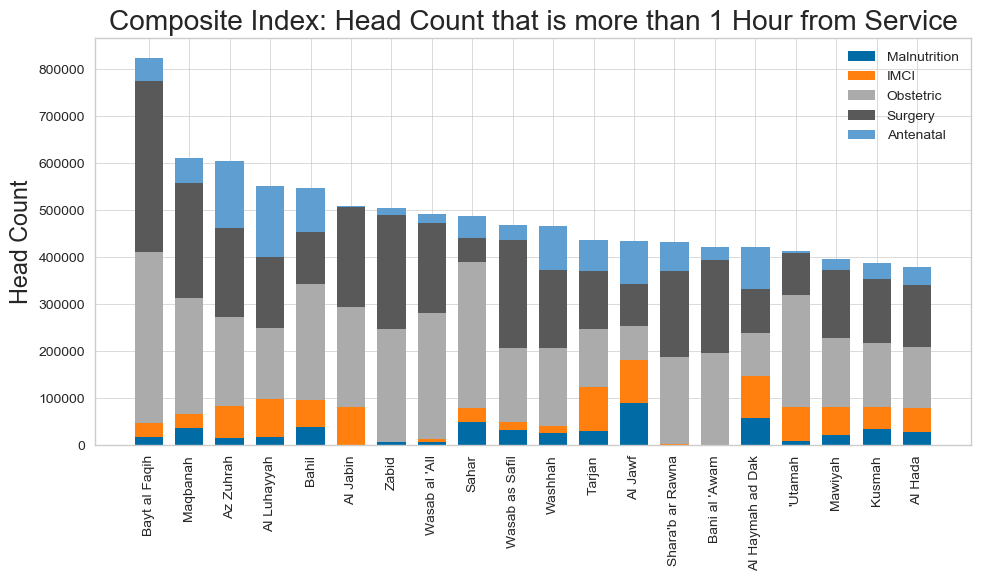

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.rcParams.update(mpl.rcParamsDefault)

for i in ['seaborn-whitegrid']:#'tableau-colorblind10
    
    print(i)
    
    fig, ax = plt.subplots()
    plt.style.use(i)
    N = 20

    malnutrition = df['Malnutrition > %s minutes' % time_thresh]
    IMCI = df['IMCI > %s minutes' % time_thresh]
    Obstetric = df['Obstetric > %s minutes' % time_thresh]
    Surgery = df['Surgery > %s minutes' % time_thresh]
    Antenatal = df['Antenatal > %s minutes' % time_thresh]

    ind = np.arange(N)    # the x locations for the groups
    width = 0.7     # the width of the bars: can also be len(x) sequence

    p1 = plt.bar(ind, malnutrition, width)
    p2 = plt.bar(ind, IMCI, width,bottom=malnutrition)
    p3 = plt.bar(ind, Obstetric, width,bottom=IMCI+malnutrition)
    p4 = plt.bar(ind, Surgery, width, bottom=malnutrition+IMCI+Obstetric)
    p5 = plt.bar(ind, Antenatal, width, bottom=Surgery+malnutrition+IMCI+Obstetric)

    plt.ylabel('Head Count')
    plt.title('Composite Index: Head Count that is more than 1 Hour from Service')
    plt.xticks(ind, (df['District Name']), rotation = 90)
    plt.yticks()
    fig = plt.gcf()
    fig.set_size_inches(10, 6)
    ax.get_yaxis().get_major_formatter().set_scientific(False)
    plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ('Malnutrition', 'IMCI','Obstetric','Surgery','Antenatal'))
    plt.tight_layout(pad=1, w_pad=1, h_pad=2.0)
    plt.savefig(os.path.join(basepth, 'output_layers','fig1.png'), dpi = 400)
    plt.show()

In [12]:
def zonalStats(inShp, inRaster, bandNum=1, mask_A = None, reProj = False, minVal = '', maxVal = '', verbose=False , rastType='N', unqVals=[]):
    import sys, os, inspect, logging, json
    import rasterio, affine

    import pandas as pd
    import geopandas as gpd
    import numpy as np

    from collections import Counter
    from shapely.geometry import box
    from affine import Affine
    from rasterio import features
    from rasterio.mask import mask
    from rasterio.features import rasterize
    from rasterio.warp import reproject, Resampling
    from osgeo import gdal
    
    ''' Run zonal statistics against an input shapefile
    
    INPUT VARIABLES
    inShp [string or geopandas object] - path to input shapefile
    inRaster [string or rasterio object] - path to input raster
    
    OPTIONAL
    bandNum [integer] - band in raster to analyze
    reProj [boolean] -  whether to reproject data to match, if not, raise an error
    minVal [number] - if defined, will only calculation statistics on values above this number
    verbose [boolean] - whether to be loud with responses
    rastType [string N or C] - N is numeric and C is categorical. Categorical returns counts of numbers
    unqVals [array of numbers] - used in categorical zonal statistics, tabulates all these numbers, will report 0 counts
    mask_A [numpy boolean mask] - mask the desired band using an identical shape boolean mask. Useful for doing conditional zonal stats
    
    RETURNS
    array of arrays, one for each feature in inShp
    '''   
    if isinstance(inShp, str):
        inVector = gpd.read_file(inShp) 
    else:
        inVector = inShp
    if isinstance(inRaster, str):
        curRaster = rasterio.open(inRaster, 'r+')
    else:
        curRaster = inRaster
        
    # If mask is not none, apply mask 
    if mask_A is not None:
        
        curRaster.write_mask(np.invert(mask_A))
    
    outputData=[]
    if inVector.crs != curRaster.crs:
        if reProj:
            inVector = inVector.to_crs(curRaster.crs)
        else:
            raise ValueError("Input CRS do not match")
    fCount = 0
    tCount = len(inVector['geometry'])
    #generate bounding box geometry for raster bbox
    b = curRaster.bounds
    rBox = box(b[0], b[1], b[2], b[3])
    for geometry in inVector['geometry']:
        #This test is used in case the geometry extends beyond the edge of the raster
        #   I think it is computationally heavy, but I don't know of an easier way to do it
        if not rBox.contains(geometry):
            geometry = geometry.intersection(rBox)            
        try:
            fCount = fCount + 1
            if fCount % 1000 == 0 and verbose:
                tPrint("Processing %s of %s" % (fCount, tCount) )
            # get pixel coordinates of the geometry's bounding box
            ul = curRaster.index(*geometry.bounds[0:2])
            lr = curRaster.index(*geometry.bounds[2:4])
            '''
            TODO: There is a problem with the indexing - if the shape falls outside the boundaries, it errors
                I want to change it to just grab what it can find, but my brain is wrecked and I cannot figure it out
            print(geometry.bounds)
            print(curRaster.shape)
            print(lr)
            print(ul)
            lr = (max(lr[0], 0), min(lr[1], curRaster.shape[1]))
            ul = (min(ul[0], curRaster.shape[0]), min(ul[1]))
            '''
            # read the subset of the data into a numpy array
            window = ((float(lr[0]), float(ul[0]+1)), (float(ul[1]), float(lr[1]+1)))
            
            if mask is not None:
                data = curRaster.read(bandNum, window=window, masked = True)
            else:
                data = curRaster.read(bandNum, window=window, masked = False)
            
            # create an affine transform for the subset data
            t = curRaster.transform
            shifted_affine = Affine(t.a, t.b, t.c+ul[1]*t.a, t.d, t.e, t.f+lr[0]*t.e)

            # rasterize the geometry
            mask = rasterize(
                [(geometry, 0)],
                out_shape=data.shape,
                transform=shifted_affine,
                fill=1,
                all_touched=False,
                dtype=np.uint8)

            # create a masked numpy array
            masked_data = np.ma.array(data=data, mask=mask.astype(bool))
            if rastType == 'N':                
                if minVal != '' or maxVal != '':
                    if minVal != '':
                        masked_data = np.ma.masked_where(masked_data < minVal, masked_data)
                    if maxVal != '':
                        masked_data = np.ma.masked_where(masked_data > maxVal, masked_data)                    
                    if masked_data.count() > 0:                        
                        results = [masked_data.sum(), masked_data.min(), masked_data.max(), masked_data.mean()]
                    else :
                        results = [-1, -1, -1, -1]                
                else:
                    results = [masked_data.sum(), masked_data.min(), masked_data.max(), masked_data.mean()]
            if rastType == 'C':
                if len(unqVals) > 0:                          
                    xx = dict(Counter(data.flatten()))
                    results = [xx.get(i, 0) for i in unqVals]                
                else:
                    results = np.unique(masked_data, return_counts=True)                    
            outputData.append(results)
        except Exception as e: 
            print(e)
            outputData.append([-1, -1, -1, -1])            
    return outputData   